# 0 - Text classification

## Importation des modules

In [1]:
# Modules de base
import pandas as pd
import sys

# Ajout d'un chemin
sys.path.append('..')

# Modules de Machine Learning
# Séparation train/test
from sklearn.model_selection import train_test_split
# Métriques
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Pipeline
from sklearn.pipeline import Pipeline
# Classifieurs
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


# Modules ad hoc
# Modules graphiques
from src.graphs.styles import set_igf_style
from src.graphs.graphs import build_hisplot, build_barplot, build_wordcloud
# Modules de preprocessing
from src.preprocessing.transformers import TokenizerTransformer, TFIDFTransformer, Word2VecTransformer
# Estimateurs
from src.estimators.classifier import LLMClassifier, ZeroShotClassifier
# Utilitaires
from src.utils.utils import fit_and_predict, evaluate_categorical_predictions

# Initialisation du style des graphiques
set_igf_style()

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


## Importation des données

### Jeu de données d'entraînement

In [2]:
# Importation du jeu de données d'entrainement
data_train = pd.read_excel('../data/data_train.xlsx', index_col='Unnamed: 0')
# Conversion des labels en types numériques
data_train['label'] = data_train['label'].replace({'1' : 0, '8' : 1, '1:8' : 2})
data_train.head(10)

,label,message
0,1,"Madame,Monsieur, je me permet de vous envoyer ..."
5,1,je désire connaitre quel est le montant de mo...
6,1,"Bonjour, Je fais suite du dernier message envo..."
7,1,"Bonjour, Je me permets de vous contacter afin ..."
8,1,"Madame, Monsieur, Après avoir déclaré nos r..."
9,0,Bonjour suite a ma derniere demande et votre r...
10,1,"A l'attention de Madame XXXXX XXXXX Bonjour, J..."
11,0,bonjour j'ai changé d'employeur depuis le 000...
12,0,"Madame, Monsieur, Bonjour, nous sommes XXXXX́s..."
13,1,"Madame, Monsieur bonjour, Je suis désolé mai..."


### Jeu de données de test

In [3]:
# Importation du jeu de données de test
data_test = pd.read_excel('../data/data_test.xlsx', index_col='Unnamed: 0')
data_test.head()

,message
0,"Chère Madame, Cher Monsieur, Impossible de ch..."
1,"Bonjour, mon taux pour le prélévement à la ..."
2,"Bonsoir, Le 0000.0000.0000 ma première fille ..."
3,"Bonjour, Lors de ma déclaration de changement..."
4,Bonjour concernant le prélèvement a la sourc...


## Statistiques descriptives

### Longueur des textes dans les jeux de données d'entraînement et de test

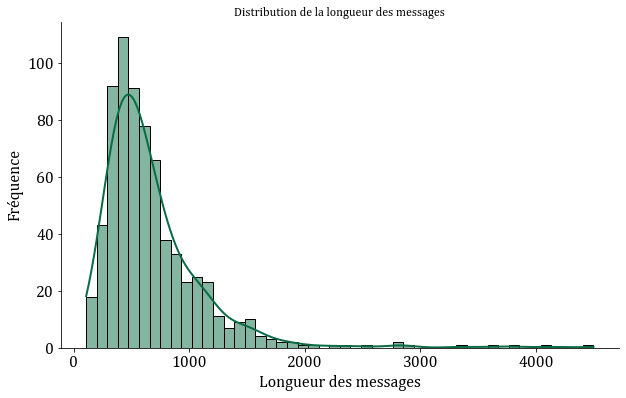

In [4]:
# Construction de la distribution de la longueur des textes
build_hisplot(data=data_train['message'].str.len(), title='Distribution de la longueur des messages', xlabel='Longueur des messages', ylabel='Fréquence')

### Distribution des labels dans le jeu de données d'entraînement

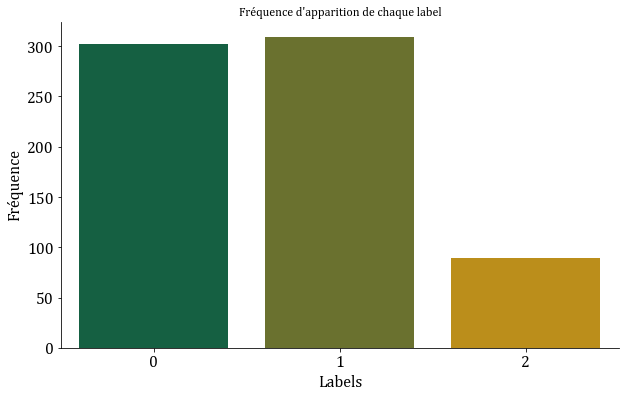

In [5]:
# Distribution des labels
build_barplot(data=data_train['label'], title="Fréquence d'apparition de chaque label", xlabel='Labels', ylabel='Fréquence')

### Caractérisation des textes labélisés

#### Label 1

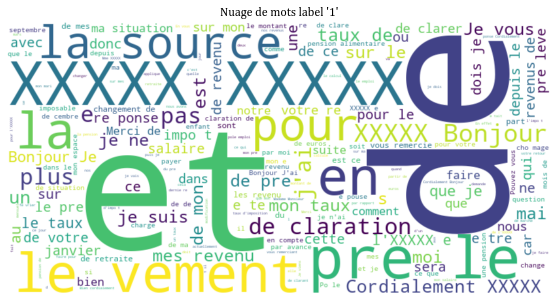

In [6]:
build_wordcloud(text=" ".join(data_train.loc[data_train['label']==0, 'message']), title="Nuage de mots label '1'")

100%|██████████| 302/302 [00:02<00:00, 145.35it/s]


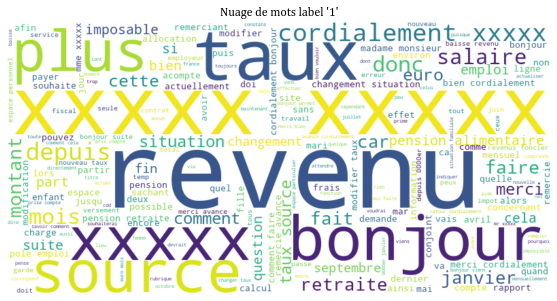

In [7]:
lemmatized_label_1 = TokenizerTransformer(text_colums=['message'], lemmatize=True).fit_transform(data_train.loc[data_train['label']==0, ['message']])
build_wordcloud(text=" ".join(lemmatized_label_1['message']), title="Nuage de mots label '1'")

#### Label 8

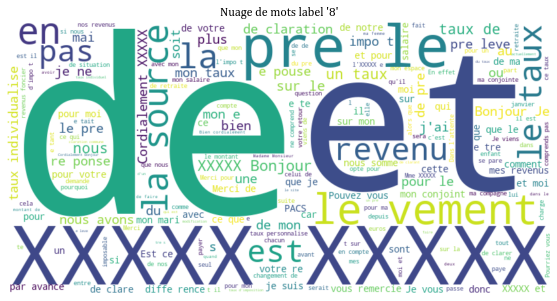

In [8]:
build_wordcloud(text=" ".join(data_train.loc[data_train['label']==1, 'message']), title="Nuage de mots label '8'")

100%|██████████| 309/309 [00:00<00:00, 726.98it/s]


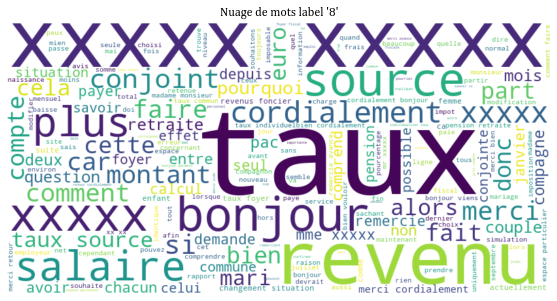

In [9]:
lemmatized_label_8 = TokenizerTransformer(text_colums=['message'], lemmatize=True).fit_transform(data_train.loc[data_train['label']==1, ['message']])
build_wordcloud(text=" ".join(lemmatized_label_8['message']), title="Nuage de mots label '8'")

#### Label 1:8

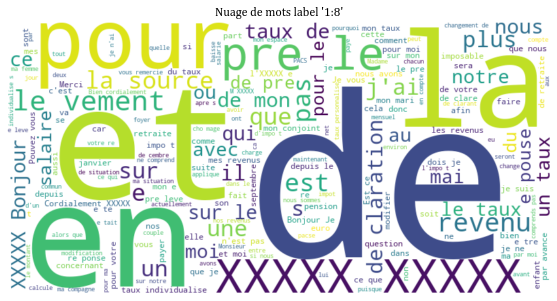

In [10]:
build_wordcloud(text=" ".join(data_train.loc[data_train['label']==2, 'message']), title="Nuage de mots label '1:8'")

100%|██████████| 89/89 [00:00<00:00, 597.62it/s]


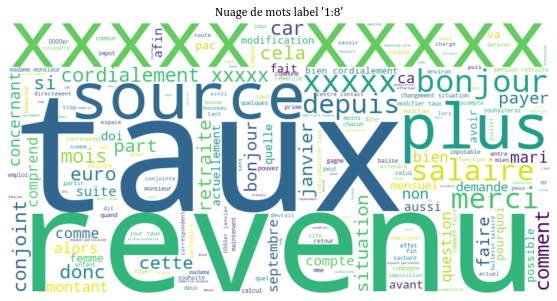

In [11]:
lemmatized_label_18 = TokenizerTransformer(text_colums=['message'], lemmatize=True).fit_transform(data_train.loc[data_train['label']==2, ['message']])
build_wordcloud(text=" ".join(lemmatized_label_18['message']), title="Nuage de mots label '1:8'")

## Preprocessing

In [12]:
# Séparation du jeu de données en jeu de données d'entraînement et jeu de données de validation
train_df, val_df = train_test_split(data_train, test_size=0.2, random_state=42)
# Séparation en X et y
X_train, y_train = train_df.drop('label', axis=1), train_df['label']
X_val, y_val = val_df.drop('label', axis=1), val_df['label']

## Classification des textes

In [13]:
# Initialisation du dictionnaire des métriques
dict_scores = {}

### Embeding de mots

Deux approches utilisant des embeding de mots sont essayées dans cette partie :
- TF-IDF qui ne considère que les mots seuls
- Word2Vec qui considère les mots et leur contexte

#### TF-IDF + Régression logistique

In [14]:
# Initialisation de la pipeline
pipeline_tfidf_logreg = Pipeline([
    ('Tokenizer', TokenizerTransformer(text_colums=['message'], lemmatize=True)),
    ('TF-IDF', TFIDFTransformer(text_column='message', max_features=5000)),
    ('LogisticRegression', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200))
])
# Entraînement de la pipeline et prédiction
y_pred_tfidf_logreg = fit_and_predict(estimator=pipeline_tfidf_logreg, X_train=X_train, y_train=y_train, X_test=X_val)

# Ajout des métriques
dict_scores['TF-IDF - Logistic regression'] = evaluate_categorical_predictions(y_true=y_val, y_pred=y_pred_tfidf_logreg)

# Evaluation
print("TF-IDF Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_tfidf_logreg))
print("TF-IDF Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_tfidf_logreg))

100%|██████████| 140/140 [00:00<00:00, 839.07it/s]


TF-IDF Accuracy: 0.7714285714285715
TF-IDF Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.88      0.78        57
           1       0.84      0.81      0.83        70
           2       1.00      0.08      0.14        13

    accuracy                           0.77       140
   macro avg       0.85      0.59      0.58       140
weighted avg       0.80      0.77      0.74       140



#### TF-IDF + XGBClassifier

In [15]:
# Initialisation de la pipeline
pipeline_tfidf_xgbc = Pipeline([
    ('Tokenizer', TokenizerTransformer(text_colums=['message'], lemmatize=True)),
    ('TF-IDF', TFIDFTransformer(text_column='message', max_features=5000)),
    ('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])

# Entraînement de la pipeline et prédiction
y_pred_tfidf_xgbc = fit_and_predict(estimator=pipeline_tfidf_xgbc, X_train=X_train, y_train=y_train, X_test=X_val)

# Ajout des métriques
dict_scores['TF-IDF - XGBClassifier'] = evaluate_categorical_predictions(y_true=y_val, y_pred=y_pred_tfidf_xgbc)

# # Entraînement de la pipeline
# pipeline_tfidf_xgbc.fit(X_train, y_train)
# # Prédiction
# y_pred_tfidf_xgbc = pipeline_tfidf_xgbc.predict(X_val)
# Evaluation
print("TF-IDF Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_tfidf_xgbc))
print("TF-IDF Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_tfidf_xgbc))

100%|██████████| 140/140 [00:00<00:00, 843.79it/s]


TF-IDF Accuracy: 0.7785714285714286
TF-IDF Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.86      0.79        57
           1       0.84      0.81      0.83        70
           2       0.60      0.23      0.33        13

    accuracy                           0.78       140
   macro avg       0.72      0.63      0.65       140
weighted avg       0.77      0.78      0.77       140



#### Word2Vec + Régression logistique

In [16]:
# Initialisation de la pipeline
pipeline_word2vec_logreg = Pipeline([
    ('Tokenizer', TokenizerTransformer(text_colums=['message'], lemmatize=True)),
    ('Word2Vec', Word2VecTransformer(text_column='message', num_features=100, window=5)),
    ('LogisticRegression', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200))
])

# Entraînement de la pipeline et prédiction
y_pred_word2vec_logreg = fit_and_predict(estimator=pipeline_word2vec_logreg, X_train=X_train, y_train=y_train, X_test=X_val)

# Ajout des métriques
dict_scores['Word2Vec - Logistic regression'] = evaluate_categorical_predictions(y_true=y_val, y_pred=y_pred_word2vec_logreg)


# # Entraînement de la pipeline
# pipeline_word2vec_logreg.fit(X_train, y_train)
# # Prédiction
# y_pred_word2vec_logreg = pipeline_word2vec_logreg.predict(X_val)

# Evaluation
print("Word2Vec Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_word2vec_logreg))
print("Word2Vec Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_word2vec_logreg))

100%|██████████| 140/140 [00:00<00:00, 925.06it/s]

Word2Vec Accuracy: 0.4142857142857143
Word2Vec Classification Report:
               precision    recall  f1-score   support

           0       0.41      1.00      0.58        57
           1       1.00      0.01      0.03        70
           2       0.00      0.00      0.00        13

    accuracy                           0.41       140
   macro avg       0.47      0.34      0.20       140
weighted avg       0.67      0.41      0.25       140




c:\Users\bolli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bolli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bolli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Word2Vec + XGBClassifier

In [17]:
# Initialisation de la pipeline
pipeline_word2vec_xgbc = Pipeline([
    ('Tokenizer', TokenizerTransformer(text_colums=['message'], lemmatize=True)),
    ('Word2Vec', Word2VecTransformer(text_column='message', num_features=100, window=5)),
    ('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])

# Entraînement de la pipeline et prédiction
y_pred_word2vec_xgbc = fit_and_predict(estimator=pipeline_word2vec_xgbc, X_train=X_train, y_train=y_train, X_test=X_val)

# Ajout des métriques
dict_scores['Word2Vec - XGBClassifier'] = evaluate_categorical_predictions(y_true=y_val, y_pred=y_pred_word2vec_xgbc)


# # Entraînement de la pipeline
# pipeline_word2vec_xgbc.fit(X_train, y_train)
# # Prédiction
# y_pred_word2vec_xgbc = pipeline_word2vec_xgbc.predict(X_val)

# Evaluation
print("Word2Vec Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_word2vec_xgbc))
print("Word2Vec Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_word2vec_xgbc))

100%|██████████| 140/140 [00:00<00:00, 771.43it/s]


Word2Vec Accuracy: 0.5928571428571429
Word2Vec Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.60      0.59        57
           1       0.63      0.67      0.65        70
           2       0.29      0.15      0.20        13

    accuracy                           0.59       140
   macro avg       0.50      0.47      0.48       140
weighted avg       0.58      0.59      0.58       140



### Embeding de phrases

Deux approches utilisant des embedings de phrases sont essayées ici :
- Masked language modelling (BERT)
- Causal langage modelling (ZeroShot classification)

#### BERT

In [18]:
# Initialisation du classifier
camembert_clf = LLMClassifier(text_column='message')

# Entraînement de la pipeline et prédiction
y_pred_camembert = fit_and_predict(estimator=camembert_clf, X_train=X_train.iloc[:30], y_train=y_train.iloc[:30], X_test=X_val)

# Ajout des métriques
dict_scores['CamemBERT'] = evaluate_categorical_predictions(y_true=y_val, y_pred=y_pred_camembert)


# # Entraînement du classifier
# camembert_clf.fit(X_train, y_train)
# # Prédiction
# y_pred_camembert = camembert_clf.predict(X_val)

# Evaluation
print("BERT Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_camembert))
print("BERT Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_camembert))

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

c:\Users\bolli\anaconda3\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.1024502515792847, 'eval_runtime': 7.7076, 'eval_samples_per_second': 0.778, 'eval_steps_per_second': 0.13, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.1019401550292969, 'eval_runtime': 8.821, 'eval_samples_per_second': 0.68, 'eval_steps_per_second': 0.113, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.1009289026260376, 'eval_runtime': 9.221, 'eval_samples_per_second': 0.651, 'eval_steps_per_second': 0.108, 'epoch': 3.0}
{'train_runtime': 320.9517, 'train_samples_per_second': 0.224, 'train_steps_per_second': 0.019, 'train_loss': 1.0937089920043945, 'epoch': 3.0}


Map:   0%|          | 0/140 [00:00<?, ? examples/s]

  0%|          | 0/18 [00:00<?, ?it/s]

BERT Accuracy: 0.5
BERT Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.50      1.00      0.67        70
           2       0.00      0.00      0.00        13

    accuracy                           0.50       140
   macro avg       0.17      0.33      0.22       140
weighted avg       0.25      0.50      0.33       140



c:\Users\bolli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bolli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bolli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Zero shot classification

In [18]:
# # Description des labels
# label_descriptions = {
#     0: "Question portant sur la déclaration de revenu de l'individu",
#     1: "Question portant sur la déclaration de revenu du conjoint de l'individu",
#     2: "Question portant sur la déclaration de renu de l'individu et de son conjoint",
# }

# Initialisation du classifier
zeroshot_clf = ZeroShotClassifier(text_column='message')

# Entraînement de la pipeline et prédiction
y_pred_zeroshot = fit_and_predict(estimator=zeroshot_clf, X_train=X_train, y_train=y_train, X_test=X_val)

# Ajout des métriques
dict_scores['ZeroShot'] = evaluate_categorical_predictions(y_true=y_val, y_pred=y_pred_zeroshot)

# Evaluation
print("ZeroShot Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_camembert))
print("ZeroShot Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_camembert))

Generating summary for category 0 with text length 149805
Error generating summary: index out of range in self
Generating summary for category 1 with text length 158967
Error generating summary: index out of range in self
Generating summary for category 2 with text length 70396
Error generating summary: index out of range in self


### Concaténation des scores

In [19]:
# Concaténation
data_scores = pd.concat(dict_scores, axis=1)
data_scores.loc['accuracy'].head()

TF-IDF - Logistic regression      0.771429
TF-IDF - XGBClassifier            0.778571
Word2Vec - Logistic regression    0.414286
Word2Vec - XGBClassifier          0.592857
CamemBERT                         0.500000
Name: accuracy, dtype: float64

## Prédiction

In [20]:
# Prédiction sur les données de test
data_preds = pd.Series(pipeline_tfidf_xgbc.predict(X=data_test), index=data_test.index, name='predicted_labels').to_frame()
data_preds['predicted_labels'] = data_preds['predicted_labels'].replace({0 : '1', 1 : '8', 2 : '1:8'})
# Exportation du jeu de données
data_preds.to_csv('../output/predicted_labels.csv')
data_preds.head()

100%|██████████| 300/300 [00:00<00:00, 487.47it/s]


,predicted_labels
0,1
1,8
2,8
3,1
4,8
